In [1]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MultiSportsFootball.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [4]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [5]:
class CONFIG:
  epochs = 10
  batch_size = 8
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  learning_rate = 1e-5
  num_workers = 2
  classes = ['football short pass', 'football dribble', 'football diving', 'football throw']
  videos_per_class = 50

In [6]:
class2label = {class_name: i for i, class_name in enumerate(CONFIG.classes)}
label2class = {i: class_name for i, class_name in enumerate(CONFIG.classes)}

In [7]:
def get_files_and_class_names(path, num_classes):
    video_paths = list(path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]

    path_per_class = collections.defaultdict(list)
    for p, c in zip(video_paths, classes):
        if c in CONFIG.classes:
          path_per_class[c].append(p)

    video_paths = []
    classes = []
    for c, paths in path_per_class.items():
        num_class_examples = min(len(paths), num_classes)
        paths = np.array(paths)
        indexes = np.linspace(0, len(paths) - 1, num_class_examples, dtype=int)
        class_paths = paths[indexes].tolist()
        video_paths.extend(class_paths)
        classes.extend([class2label[c] for _ in range(len(class_paths))])

    return video_paths, classes

In [8]:
# Custom Dataset class
class VideoDataset(Dataset):
    def __init__(self, file_paths, targets, transform=None):
        self.file_paths = file_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_frames = frames_from_video_file(self.file_paths[idx],
                                              n_frames=16, frame_step=4)
        video_frames = torch.FloatTensor(video_frames)

        if self.transform:
          video_frames = torch.transpose(video_frames, 0, 1)
          video_frames = self.transform(video_frames)
          video_frames = torch.transpose(video_frames, 0, 1)

        label = self.targets[idx]

        return video_frames, torch.tensor(label, dtype=torch.long)

def format_frames(frame, output_size):
    """Format frames to tensor with specified size"""
    frame = cv2.resize(frame, output_size)
    frame = frame / 255.0
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=4):
    """Extract frames from video file"""
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))

    src.release()

    result = np.array(result)
    result = np.transpose(result, (3, 0, 1, 2))  # (T, C, H, W) format
    return result

In [9]:
# Model definition
class VideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier, self).__init__()
        self.model = torch.hub.load('facebookresearch/hiera', model='hiera_large_16x224', pretrained=True, checkpoint='mae_k400_ft_k400')
        proj = self.model.head.projection
        self.model.head.projection = nn.Linear(proj.in_features, num_classes)

        # Freeze the pre-trained parameters
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.blocks[45:].parameters():
            param.requires_grad = True

        for param in self.model.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.model(x)

        return x


In [10]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(dataloader):
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(dataloader):
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_labels

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [12]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history['train_loss'], label = 'train')
  ax1.plot(history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history['train_loss'] + history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history['train_acc'],  label = 'train')
  ax2.plot(history['val_acc'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 100])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

In [13]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

In [14]:
# Load dataset
train_paths, train_classes = get_files_and_class_names(pathlib.Path('./train'),150)
val_paths, val_classes = get_files_and_class_names(pathlib.Path('./valid'),50)

# Create datasets and dataloaders

train_dataset = VideoDataset(train_paths, train_classes)
val_dataset = VideoDataset(val_paths, val_classes)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=True,
    num_workers=CONFIG.num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=False,
    num_workers=CONFIG.num_workers
)

In [15]:
# Main training loop
def main(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )

    # Training loop
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(CONFIG.epochs):
        print(f'Epoch {epoch+1}/{CONFIG.epochs}')

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, CONFIG.device
        )

        val_loss, val_acc, all_preds, all_labels = validate(
            model, val_loader, criterion, CONFIG.device
        )

        # Update learning rate
        scheduler.step(val_loss)


        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = 'best.pt'

            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            }, checkpoint_path)

        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          }, 'last.pt')

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    return history

In [16]:
# Initialize model
model = VideoClassifier(num_classes=len(CONFIG.classes)).to(CONFIG.device)

Downloading: "https://github.com/facebookresearch/hiera/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Downloading: "https://dl.fbaipublicfiles.com/hiera/hiera_large_16x224.pth" to /root/.cache/torch/hub/checkpoints/hiera_large_16x224.pth
100%|██████████| 2.38G/2.38G [02:07<00:00, 20.0MB/s]


In [60]:
history = main(model)

Epoch 1/10


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train Loss: 1.3746 Train Acc: 30.97%
Val Loss: 1.3730 Val Acc: 40.25%
Epoch 2/10


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train Loss: 1.3257 Train Acc: 45.14%
Val Loss: 1.3570 Val Acc: 57.86%
Epoch 3/10


100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


Train Loss: 1.2756 Train Acc: 53.85%
Val Loss: 1.3363 Val Acc: 58.49%
Epoch 4/10


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train Loss: 1.1877 Train Acc: 57.09%
Val Loss: 1.2807 Val Acc: 67.92%
Epoch 5/10


100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


Train Loss: 0.9696 Train Acc: 65.79%
Val Loss: 1.1251 Val Acc: 76.73%
Epoch 6/10


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train Loss: 0.7055 Train Acc: 72.67%
Val Loss: 1.0417 Val Acc: 81.13%
Epoch 7/10


100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


Train Loss: 0.5700 Train Acc: 77.73%
Val Loss: 1.0144 Val Acc: 83.02%
Epoch 8/10


100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Train Loss: 0.5002 Train Acc: 80.97%
Val Loss: 0.9841 Val Acc: 86.79%
Epoch 9/10


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train Loss: 0.4378 Train Acc: 85.22%
Val Loss: 0.9834 Val Acc: 84.91%
Epoch 10/10


100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


Train Loss: 0.4000 Train Acc: 86.03%
Val Loss: 0.9534 Val Acc: 88.05%


In [61]:
model.load_state_dict(torch.load('best.pt', weights_only=True)['model_state_dict'])

<All keys matched successfully>

100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


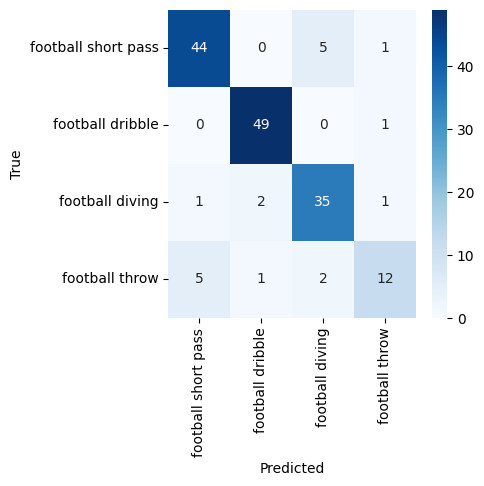

In [62]:
criterion = nn.CrossEntropyLoss()

val_loss, val_acc, all_preds, all_labels = validate(
  model, val_loader, criterion, CONFIG.device
)

plot_confusion_matrix(all_labels, all_preds, CONFIG.classes)

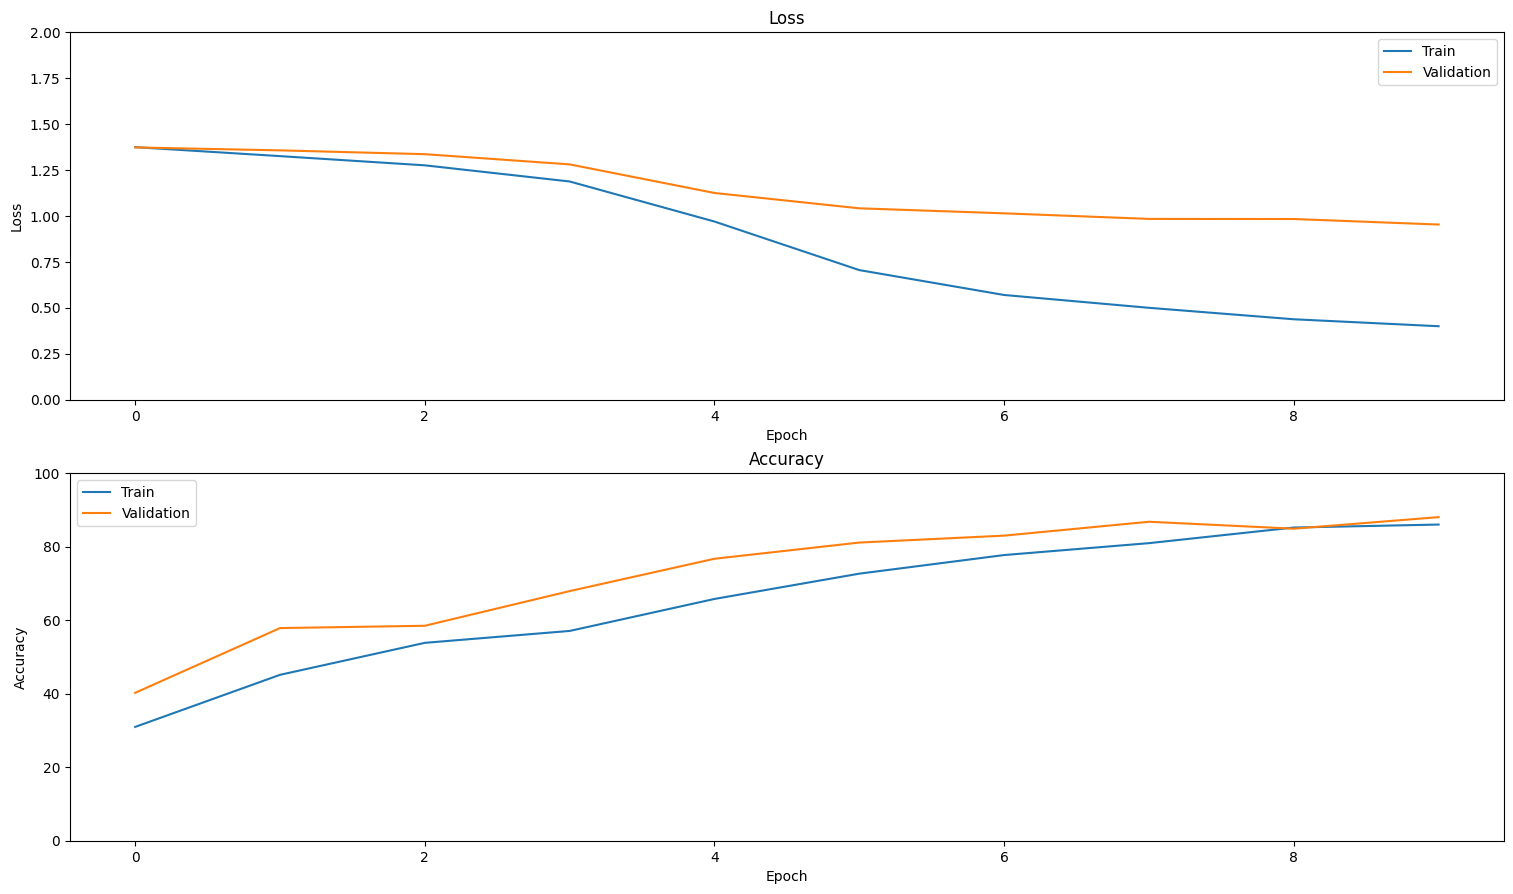

In [63]:
plot_history(history)

In [21]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    if (tp[i] + fp) == 0:
      precision[labels[i]] = 0
    else:
      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    if (tp[i] + fn) == 0:
      recall[labels[i]] = 0
    else:
      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [65]:
precision, recall = calculate_classification_metrics(all_labels, all_preds, CONFIG.classes)

In [66]:
precision

{'football short pass': 0.88,
 'football dribble': 0.9423076923076923,
 'football diving': 0.8333333333333334,
 'football throw': 0.8}

In [67]:
recall

{'football short pass': 0.88,
 'football dribble': 0.98,
 'football diving': 0.8974358974358975,
 'football throw': 0.6}

# All classes

In [25]:
CONFIG.classes = ['football shoot', 'football long pass', 'football short pass', 'football through pass', 'football cross', 'football dribble', 'football trap', 'football throw', 'football diving', 'football tackle', 'football steal', 'football clearance', 'football block', 'football press', 'football aerial duels']

In [17]:
history = main(model)

Epoch 1/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 2.6960 Train Acc: 9.30%
Val Loss: 2.7055 Val Acc: 14.68%
Epoch 2/10


100%|██████████| 86/86 [04:26<00:00,  3.09s/it]


Train Loss: 2.6511 Train Acc: 15.52%
Val Loss: 2.6995 Val Acc: 16.30%
Epoch 3/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 2.4562 Train Acc: 17.35%
Val Loss: 2.6539 Val Acc: 19.53%
Epoch 4/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 2.1909 Train Acc: 24.39%
Val Loss: 2.6368 Val Acc: 22.61%
Epoch 5/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 2.0703 Train Acc: 27.55%
Val Loss: 2.6241 Val Acc: 23.05%
Epoch 6/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 1.9819 Train Acc: 30.71%
Val Loss: 2.6188 Val Acc: 21.59%
Epoch 7/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 1.8991 Train Acc: 33.49%
Val Loss: 2.6100 Val Acc: 24.08%
Epoch 8/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 1.8304 Train Acc: 36.27%
Val Loss: 2.6054 Val Acc: 25.11%
Epoch 9/10


100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


Train Loss: 1.7639 Train Acc: 39.10%
Val Loss: 2.6041 Val Acc: 24.23%
Epoch 10/10


100%|██████████| 86/86 [04:25<00:00,  3.09s/it]


Train Loss: 1.6949 Train Acc: 42.02%
Val Loss: 2.5979 Val Acc: 25.11%


In [ ]:
model.load_state_dict(torch.load('best.pt', weights_only=True)['model_state_dict'])

100%|██████████| 86/86 [04:26<00:00,  3.10s/it]


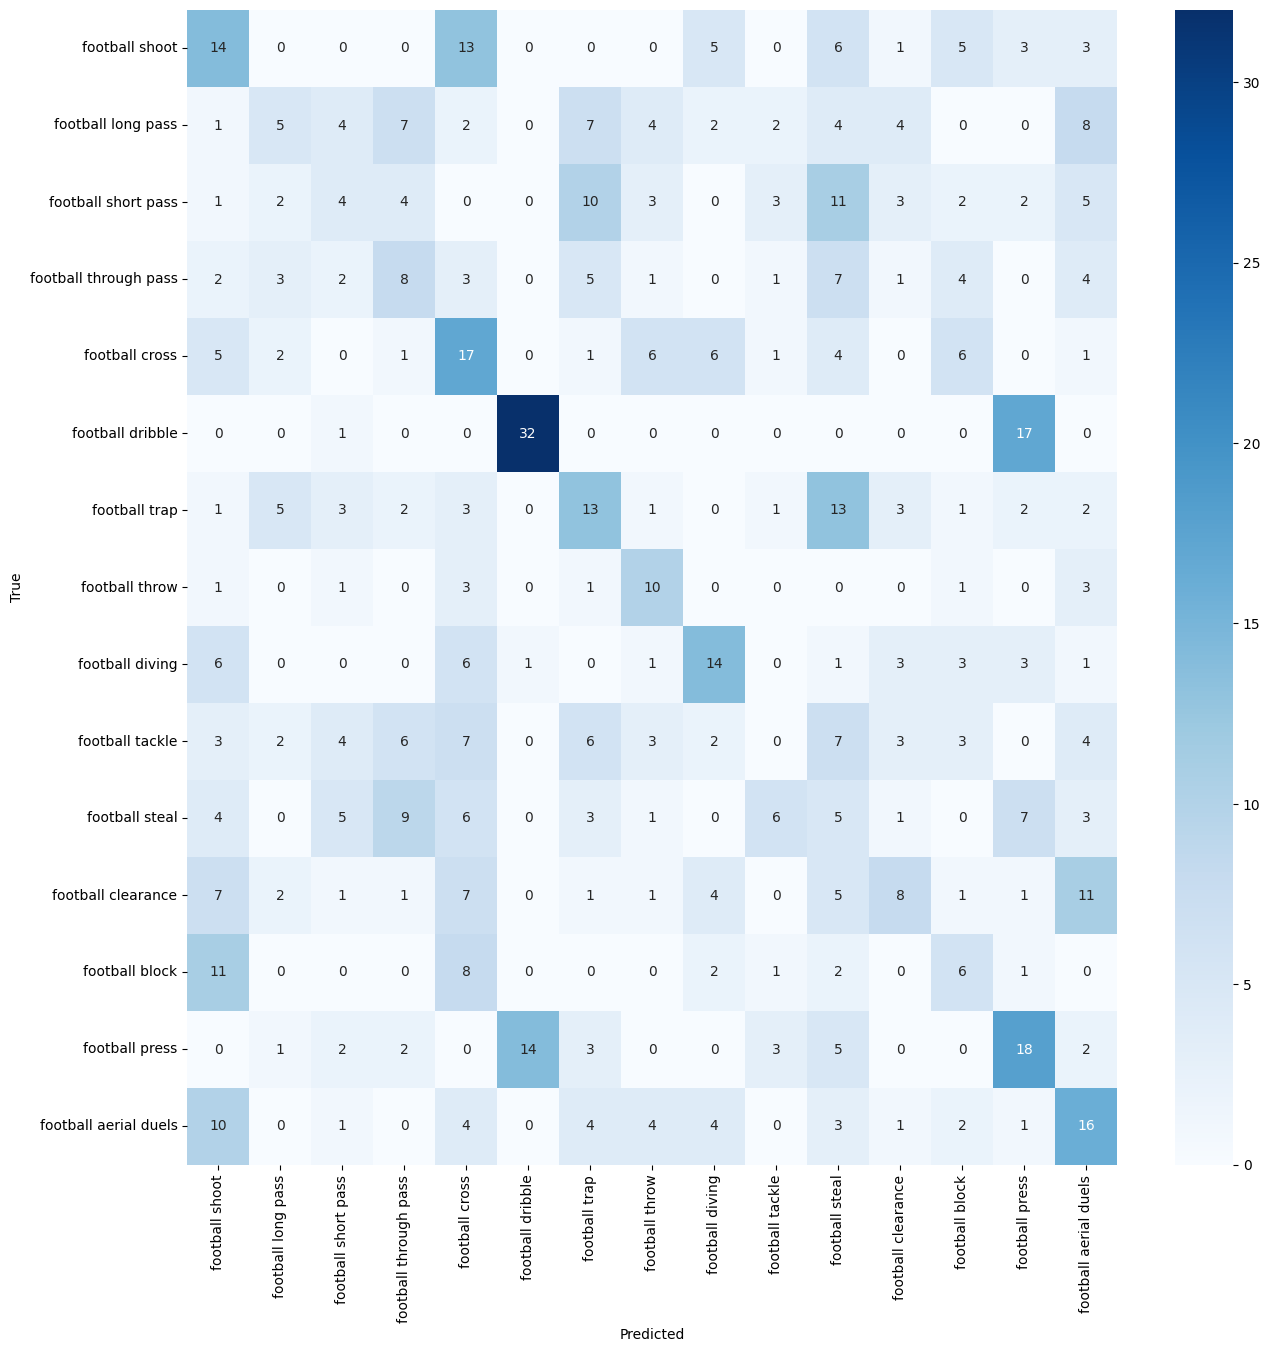

In [18]:
criterion = nn.CrossEntropyLoss()

val_loss, val_acc, all_preds, all_labels = validate(
  model, val_loader, criterion, CONFIG.device
)

plot_confusion_matrix(all_labels, all_preds, CONFIG.classes)

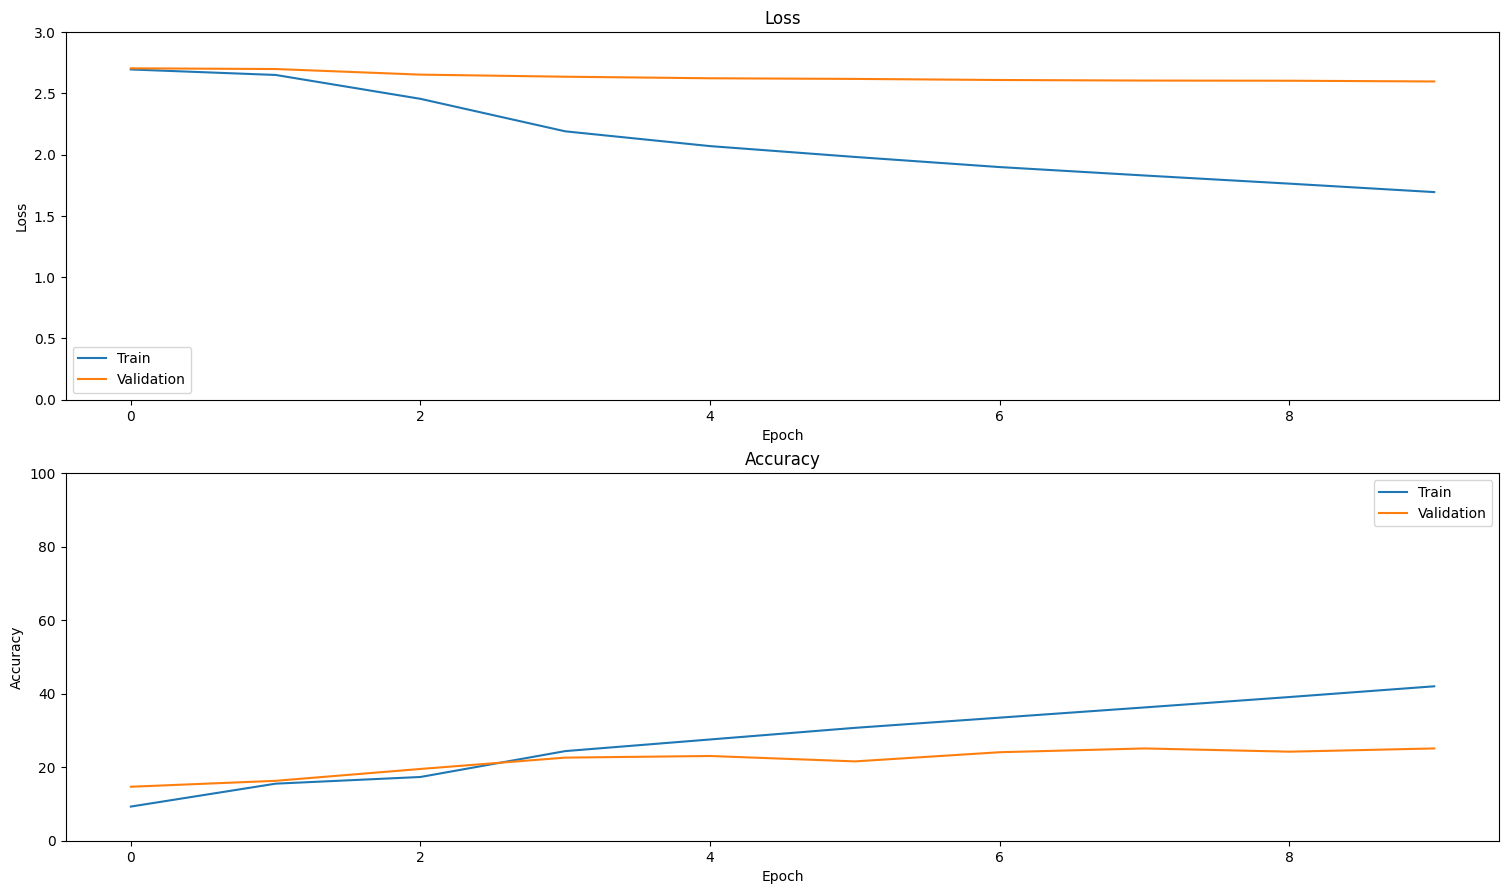

In [19]:
plot_history(history)

In [22]:
precision, recall = calculate_classification_metrics(all_labels, all_preds, CONFIG.classes)

In [23]:
precision

{'football shoot': 0.21212121212121213,
 'football long pass': 0.22727272727272727,
 'football short pass': 0.14285714285714285,
 'football through pass': 0.2,
 'football cross': 0.21518987341772153,
 'football dribble': 0.6808510638297872,
 'football trap': 0.24074074074074073,
 'football throw': 0.2857142857142857,
 'football diving': 0.358974358974359,
 'football tackle': 0.0,
 'football steal': 0.0684931506849315,
 'football clearance': 0.2857142857142857,
 'football block': 0.17647058823529413,
 'football press': 0.32727272727272727,
 'football aerial duels': 0.25396825396825395}

In [24]:
recall

{'football shoot': 0.28,
 'football long pass': 0.1,
 'football short pass': 0.08,
 'football through pass': 0.1951219512195122,
 'football cross': 0.34,
 'football dribble': 0.64,
 'football trap': 0.26,
 'football throw': 0.5,
 'football diving': 0.358974358974359,
 'football tackle': 0.0,
 'football steal': 0.1,
 'football clearance': 0.16,
 'football block': 0.1935483870967742,
 'football press': 0.36,
 'football aerial duels': 0.32}